In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0,7.0)
import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import Sequential

In [2]:
data_x = pd.read_csv("x_train.csv")
data_y = pd.read_csv("y_train.csv")

In [3]:
data_x.head(3)

,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25
0,0,0.0,90.4,5.9,3.6,0.1,79,Отсутствует,Plasticizer1,Polymer1,138,75
1,1,0.3,90.1,5.9,3.6,0.1,79,Adhesion1,Plasticizer2,Polymer2,138,75
2,2,0.3,90.1,5.9,3.6,0.1,79,Adhesion1,Plasticizer3,Polymer2,138,75


In [4]:
data_y.head(3)

,id,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,0,33.0,71.0,21.0,74.4,73.0
1,1,32.0,71.0,16.0,72.8,75.0
2,2,35.0,76.0,27.0,74.0,78.0


In [5]:
def get_train_dataset_x(data_x):
  encod_adg = LabelBinarizer()
  encod_plas = LabelBinarizer()
  encod_poly = LabelBinarizer()

  list_adg = encod_adg.fit_transform(data_x["Адгезионная добавка"])
  list_plas = encod_plas.fit_transform(data_x["Пластификатор"])
  list_poly = encod_poly.fit_transform(data_x["Полимер"])

  classificator = {"Адгезионная добавка": list_adg, "Пластификатор": list_plas, "Полимер": list_poly}
  deff = filter(lambda i: True if i not in classificator.keys() else False, data_x.columns)
  data_lab_x = data_x.copy()[deff]

  dfs = [data_lab_x]
  for k,v in classificator.items():
    df = pd.DataFrame(v, columns=[k+str(i) for i in range(v.shape[1])])
    dfs.append(df)
  data_class_x = pd.concat(dfs, axis=1)

  data_X = data_class_x.copy()
  norm = MinMaxScaler()
  res = norm.fit_transform(data_X)
  for i, el in enumerate(data_X.columns):
    data_X[el] = res[:, i]
  X_train = data_X
  X_train["id"] = range(X_train.shape[0])

  return X_train, encod_adg, encod_plas, encod_poly, norm

In [6]:
X_train, *bins = get_train_dataset_x(data_x)

In [7]:
def get_test_dataset_x(data_x, bins):
  list_adg = bins[0].transform(data_x["Адгезионная добавка"])
  list_plas = bins[1].transform(data_x["Пластификатор"])
  list_poly = bins[2].transform(data_x["Полимер"])

  classificator = {"Адгезионная добавка": list_adg, "Пластификатор": list_plas, "Полимер": list_poly}
  deff = filter(lambda i: True if i not in classificator.keys() else False, data_x.columns)
  data_lab_x = data_x.copy()[deff]

  dfs = [data_lab_x]
  for k,v in classificator.items():
    df = pd.DataFrame(v, columns=[k+str(i) for i in range(v.shape[1])])
    dfs.append(df)
  data_class_x = pd.concat(dfs, axis=1)

  data_X = data_class_x.copy()
  res = bins[-1].transform(data_X)
  for i, el in enumerate(data_class_x.columns):
    data_X[el] = res[:, i]
  X_test = data_X[data_X.columns[1:]]
  return X_test

In [8]:
test = pd.read_csv("x_test.csv")
X_test = get_test_dataset_x(test, bins)
X_test

,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25,Адгезионная добавка0,Адгезионная добавка1,...,Пластификатор19,Пластификатор20,Пластификатор21,Пластификатор22,Пластификатор23,Пластификатор24,Полимер0,Полимер1,Полимер2,Полимер3
0,0.857143,0.757576,0.252024,0.000000,0.320988,0.181818,0.245509,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.857143,0.401382,0.620179,0.263158,0.506173,0.181818,0.616766,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.857143,0.608719,0.363512,0.473684,0.654321,0.181818,0.359281,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.000000,0.539607,0.440357,0.631579,0.765432,0.181818,0.437126,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000000,0.566188,0.392202,0.789474,0.876543,0.181818,0.389222,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.857143,0.635300,0.272440,1.000000,1.024691,0.181818,0.269461,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.857143,0.667198,0.255119,0.842105,0.913580,0.181818,0.251497,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.857143,0.736310,0.214524,0.526316,0.691358,0.181818,0.209581,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.000000,0.863902,0.138571,0.105263,0.395062,0.181818,0.131737,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.000000,0.810739,0.167440,0.368421,0.580247,0.181818,0.161677,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
def get_train_dataset_y(data_y):
  data_Y = data_y.copy()
  index1 = data_Y[["id", "Эластичность при 0 °С, [%]"]].dropna()[data_Y.columns[0]].to_numpy()
  index4 = data_Y[data_Y.columns[:-1]].dropna()[data_Y.columns[0]].to_numpy()
  data_Y = data_Y[data_Y.columns[1:]]
  norm = MinMaxScaler()
  res = norm.fit_transform(data_Y)
  for i, el in enumerate(data_Y.columns):
    data_Y[el] = res[:, i]
  Y_train = data_Y
  Y_train4 = Y_train[Y_train.columns[:-1]].dropna()
  Y_train1 = Y_train[Y_train.columns[-1]].dropna()
  return Y_train1, Y_train4, norm, index1, index4

In [10]:
Y_train1, Y_train4, norm, *index = get_train_dataset_y(data_y)

Y_train4

,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]"
0,0.31250,0.184466,0.178571,0.733333
1,0.28125,0.184466,0.089286,0.657143
2,0.37500,0.233010,0.285714,0.714286
3,0.21875,0.126214,0.035714,0.761905
4,0.28125,0.135922,0.053571,0.761905
...,...,...,...,...
103,0.34375,0.184466,0.696429,0.714286
104,0.28125,0.184466,0.244643,0.714286
105,0.25000,0.194175,0.232143,0.666667
106,0.28125,0.126214,0.089286,0.761905


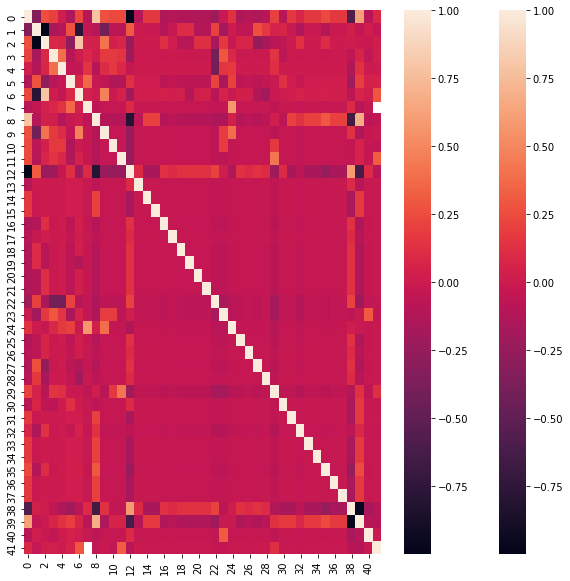

In [11]:
import seaborn as sns
X_train, *bins = get_train_dataset_x(data_x)
X_train4 = X_train[X_train["id"].isin(index[1])][X_train.columns[1:]]
X_train1 = X_train[X_train["id"].isin(index[0])][X_train.columns[1:]]
plt.figure(figsize = (10,10))
sns.heatmap(data=X_train4.corr().to_numpy(), annot=False)
sns.heatmap(data=X_train1.corr().to_numpy(), annot=False)

#Создание модели обучения

In [12]:
import tensorflow as tf
import gc
mods = []
hists = []
num = 0
for dop in [False, True]:
  for act in ["sigmoid", "relu"]:
    for end in ["sigmoid","elu"]:
      for k in [10,20,30,40,50,60,70,80,90,100]:
        models = []
        layers = [k]*2

        model4 = Sequential()
        model4.add(Dense(layers[0], activation=act, input_shape = (X_train4.shape[1],)))
        if dop:
          model4.add(Dense(int(layers[0]/2), activation=act))
        model4.add(Dense(4, activation=end))
        model4.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])

        model1 = Sequential()
        model1.add(Dense(layers[1], activation=act, input_shape = (X_train4.shape[1],)))
        if dop:
          model1.add(Dense(int(layers[1]/2), activation=act))
        model1.add(Dense(1, activation=end))
        model1.compile(optimizer="Adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
        
        models.append(model4)
        models.append(model1)
        historys = []
        num += 1
        for i, el in enumerate(models):
          if i!=1:
            history = el.fit(X_train4, Y_train4, epochs=70, validation_split = 0.1, batch_size=120, verbose=0)
          else:
            history = el.fit(X_train1, Y_train1, epochs=70, validation_split = 0.1, batch_size=120, verbose = 0)
          historys.append(history)
          print("\r",dop, act, end, k, i, end = " ")
          maximum = 2*2*2*(100-10)
          print(f" |  {int(num/maximum*100)} % ","[","="*int(num/maximum*100), "-"*int(100-num/maximum*100),"]", sep="", end="")
          gc.collect()
        hists.append(historys)
        mods.append(models)

 True relu elu 100 1  |  11 % [===========----------------------------------------------------------------------------------------]

In [13]:
'''for historys in hists:
  fig, plots = plt.subplots(
      nrows=2, ncols=3,
      figsize=(20, 8)
  )
  plots = plots.reshape(-1)
  for i in range(len(plots)-1):
    plots[i].plot(historys[i].history['val_root_mean_squared_error'],color = 'g',linewidth = 4)
    plots[i].grid(True)
    plots[i].set_title('Процесс обучения')
    plots[i].set_xlabel('Эпоха обучения')
    plots[i].set_ylabel('Средний квадрат ошибки')
    fig.show()'''

A = np.array([[i.history['val_root_mean_squared_error'][-1] for i in historys] for historys in hists])
A.min(0)

array([0.11492953, 0.1311634 ])

In [14]:
test = pd.read_csv("x_test.csv")
X_test = get_test_dataset_x(test, bins)
model4_old = tf.keras.models.load_model("model4_1331.h5")
model1_old = tf.keras.models.load_model("model1_1331.h5")
Y_test4 = model4_old.predict(X_test)
Y_test1 = model1_old.predict(X_test)
num = Y_test4.shape[0]
result = np.ones((num, 5))
result[:,0:-1] = Y_test4
result[:,-1] =Y_test1.reshape(-1)
Fin = norm.inverse_transform(result).round(1)
Fin

array([[32.6, 68.8, 10. , 74.7, 75.8],
       [41.8, 68.1, 38.3, 74. , 80.8],
       [36.8, 75.1, 20.5, 77.3, 77.4],
       [32.2, 78.9, 29.6, 69.9, 73. ],
       [28.4, 74.7, 30.8, 74.3, 72.1],
       [30.7, 78.1, 28.2, 80.6, 78.4],
       [32.2, 86.4, 26.9, 77.9, 79.3],
       [26.2, 68.9, 25.2, 66.2, 77.8],
       [31.6, 77.6, 27.8, 62.6, 78.1],
       [30.9, 65. , 28.2, 71.4, 76.7]])

In [14]:

test = pd.read_csv("x_test.csv")
X_test = get_test_dataset_x(test, bins)
Fins = []
n=0
for k in mods:
  Y_tests = []
  for i in k:
    Y_tests.append(i.predict(X_test))
  num = Y_tests[0].shape[0]
  result = np.ones((num, 5))
  result[:,:-1] = Y_tests[0]
  result[:,-1] = Y_tests[1].reshape(-1)
  Fin = norm.inverse_transform(result)
  n+=1
  print("\r",n, end="")
  Fins.append(Fin)
Fins

 2

 80

[array([[36.66607761, 79.08412352, 33.50445867, 72.50643104, 75.6270633 ],
        [36.14824486, 78.26466799, 34.48716307, 72.97637087, 75.81485304],
        [36.11330318, 81.80964696, 33.70597196, 72.48101407, 76.59769604],
        [35.42777729, 77.09508634, 34.90306377, 72.27260143, 74.96319103],
        [35.38728237, 77.54104045, 35.32307172, 72.55748653, 75.18021634],
        [36.12398815, 75.83141257, 32.96537423, 72.0754866 , 76.05990309],
        [35.34597206, 77.01130207, 33.94806528, 72.85016847, 75.67217892],
        [36.12106705, 76.99801667, 33.02151704, 72.01606101, 75.19342321],
        [35.92856884, 77.6911366 , 33.62044597, 71.89041811, 76.17616692],
        [35.72579193, 74.68878388, 35.32849574, 72.46120971, 75.04325417]]),
 array([[34.3271513 , 77.72412448, 29.58214593, 72.14611739, 75.22600609],
        [34.39998913, 77.10100614, 28.32042813, 72.00280553, 76.58924696],
        [34.27808571, 75.99610792, 30.64115715, 72.66067022, 74.87008438],
        [34.31884956, 7

In [15]:
from tensorflow.python.framework.ops import colocate_with
Y_tests = []
for i in Fins:
  df = pd.DataFrame(i, columns=data_y.columns[1:])
  sr = pd.Series(range(num), name="id")
  Y_test = pd.concat([sr, df], axis = 1)
  Y_tests.append(Y_test)
#Y_test.to_csv("result.csv", index=False)
y_real = pd.read_csv("submission_example.csv")
#y_real = data_y.head(10)
mat = []
for k in Y_tests:
  col = []
  for i in range(1,y_real.shape[1]):
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(k.to_numpy()[:,i], y_real.to_numpy()[:, i])
    col.append(m.result().numpy())
  mat.append(col)
  print()
  m = tf.keras.metrics.RootMeanSquaredError()
  m.update_state(k.to_numpy()[:,1:], y_real.to_numpy()[:, 1:])
  print(m.result().numpy())
  print("----------------------------------")
print(np.array(mat))


5.2067184
----------------------------------

4.102285
----------------------------------

8.574482
----------------------------------

3.8879404
----------------------------------

5.1755414
----------------------------------

3.777804
----------------------------------

4.133933
----------------------------------

3.9395173
----------------------------------

3.8203297
----------------------------------

3.94072
----------------------------------

10.033765
----------------------------------

7.293914
----------------------------------

4.6334615
----------------------------------

5.218071
----------------------------------

5.967488
----------------------------------

6.29993
----------------------------------

3.8166525
----------------------------------

5.7426887
----------------------------------

4.7528243
----------------------------------

5.162501
----------------------------------

6.343928
----------------------------------

6.4733787
----------------------------------



In [16]:
result = np.array(mat)
print(result.argmin(0), result.min(0), sep = "\n")
print()
f = []
for i in range(5):
  f.append(Fins[result.argmin(0)[i]][:, i])
f = np.array(f).T
df = pd.DataFrame(f, columns=data_y.columns[1:])
sr = pd.Series(range(num), name="id")
Y = pd.concat([sr, df], axis = 1)

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(Y.to_numpy()[:,1:], y_real.to_numpy()[:, 1:])
print(m.result().numpy().round(2))
Y

[54 57 16 33  1]
[1.207996  4.9706254 4.0632515 2.1338265 1.4787735]

3.14


,id,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,0,31.608199,76.657822,20.982218,66.972278,75.226006
1,1,32.790006,77.559862,33.155676,69.260709,76.589247
2,2,33.002205,77.969461,25.289788,71.462235,74.870084
3,3,32.456013,76.468797,30.872434,70.293436,74.548965
4,4,32.230610,76.524167,30.579392,73.437596,74.253189
5,5,32.631433,74.391339,26.672263,73.071231,74.001414
6,6,32.656375,74.739361,29.264170,73.872134,74.545585
7,7,32.139563,74.737350,21.172083,70.134031,74.895236
8,8,32.740170,77.491203,30.668621,69.121156,75.672937
9,9,32.010789,76.370656,30.005662,74.219894,76.123874


In [17]:
strukt = list([[dop, act, k]for dop in [False, True] for act in ["sigmoid", "relu"] for end in ["sigmoid","elu"] for k in range(10,101,10)])
for i in result.argmin(0):
  print(strukt[i])


[True, 'sigmoid', 50]
[True, 'sigmoid', 80]
[False, 'sigmoid', 70]
[False, 'relu', 40]
[False, 'sigmoid', 20]


In [18]:
Y.to_csv("result_8.csv", index=False)

In [19]:
for i, el in enumerate(result.argmin(0)):
  if i==4:
    mods[el][1].save("model4_5.h5")
  else:
    mods[el][0].save(f"model{i}_5.h5")